**ссылки на требуемые документы:**

https://disk.yandex.ru/d/utmgebPbkO2adQ (data.csv) население России по городам (нужна в п.2.1)

https://disk.yandex.ru/i/pbMmFV050MOXKA документ с информацией о населении Казахстана (нужна в пункте 2.4). Не подгружался , но цифры брались оттуда.

# Загрузка данных по донации и первичная обработка

In [1]:
#!pip instal natasha библиотека наташа для русских слов

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from functools import lru_cache
from natasha import MorphVocab, AddrExtractor
from io import BytesIO 
import requests

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Данные (обработанная таблица `users`) подгружается с с гугл диска  

In [3]:
spreadsheet_id = """1k7OKuSlwWPOIfMaIRS87ixVNXpHQ6mP5BIyjRNKl4Q8"""
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)

In [4]:
df_1 = pd.read_csv(BytesIO(r.content))
df_1

,Unnamed: 0,ID,Пол,Дата рождения,Регион,Группа крови,Kell-фактор,Цельная кровь,Плазма,Тромбоциты,...,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата регистрации,Не подтверждённые донации,Страна,Область,Город,Возраст
0,0,178985,Женский,2003-03-03,Не указано,Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2021-12-15,0,Не указано,NaN,NaN,18.0
1,1,178984,Мужской,1981-01-25,Не указано,Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2021-12-15,0,Не указано,NaN,NaN,40.0
2,2,178983,Не указано,NaN,"Россия, Москва",B(III) Rh-,Отрицательный,Да,Да,Нет,...,0,0,0,0,2021-12-15,1,Россия,Москва,NaN,NaN
3,3,178982,Не указано,NaN,Не указано,O(I) Rh+,Положительный,Да,Да,Да,...,0,0,0,0,2021-12-15,0,Не указано,NaN,NaN,NaN
4,4,178981,Женский,1995-06-19,Не указано,Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2021-12-15,0,Не указано,NaN,NaN,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177010,177905,117648,Не указано,NaN,"Россия, Санкт-Петербург",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,Россия,Санкт-Петербург,NaN,NaN
177011,177906,6340,Не указано,NaN,"Россия, Санкт-Петербург",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,Россия,Санкт-Петербург,NaN,NaN
177012,177907,6266,Не указано,NaN,"Россия, Санкт-Петербург",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,Россия,Санкт-Петербург,NaN,NaN
177013,177908,117647,Не указано,NaN,"Египет, Cairo",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,Египет,Cairo,NaN,NaN


In [5]:
df_1 = df_1.drop(['Страна','Область', 'Город'], axis =1)

Удалил столбцы: `'Страна','Область','Город'` - посчитал, что простым разделением `.split` - действовать не есть сильно хорошо (эти столбцы были полученны именно так), так как есть города без указания областей .Поэтому по совету на stackoverflow применил такую функцию: 

In [6]:
morph_vocab = MorphVocab()
addr_extractor = AddrExtractor(morph=morph_vocab)

@lru_cache(maxsize=2048)
def parse_addr(addr_str, addr_extractor=addr_extractor):
    ext = addr_extractor.find(addr_str)
    if not ext:
        return pd.Series(dtype=str)
    res = pd.Series(
        {part.type if part.type else "Город": part.value 
         for part in ext.fact.parts},
        dtype=str
    )
    return res

Эта функция по городу определяет его: область,край,ао - и помещает в соответствующий столбец.

Не сказать, что это тоже хороший подход, так как в конечном итоге все равно пришлось все сводить в один столбец. Я выбрал `область`.

еще данная функция не определяла края - их пришлось вбивать вручную. 

В общем неоднозначный подход. **Может есть лучше варианты?**

In [7]:
res = df_1.join(df_1["Регион"].apply(parse_addr))

In [8]:
res

,Unnamed: 0,ID,Пол,Дата рождения,Регион,Группа крови,Kell-фактор,Цельная кровь,Плазма,Тромбоциты,...,Лейкоциты.1,Дата регистрации,Не подтверждённые донации,Возраст,страна,Город,область,край,автономный округ,деревня
0,0,178985,Женский,2003-03-03,Не указано,Не указано,Не указано,Да,Да,Да,...,0,2021-12-15,0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,178984,Мужской,1981-01-25,Не указано,Не указано,Не указано,Да,Да,Да,...,0,2021-12-15,0,40.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,178983,Не указано,NaN,"Россия, Москва",B(III) Rh-,Отрицательный,Да,Да,Нет,...,0,2021-12-15,1,NaN,Россия,Москва,NaN,NaN,NaN,NaN
3,3,178982,Не указано,NaN,Не указано,O(I) Rh+,Положительный,Да,Да,Да,...,0,2021-12-15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,178981,Женский,1995-06-19,Не указано,Не указано,Не указано,Да,Да,Да,...,0,2021-12-15,0,26.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177010,177905,117648,Не указано,NaN,"Россия, Санкт-Петербург",Не указано,Не указано,Да,Да,Да,...,0,2018-09-04,0,NaN,Россия,Санкт-Петербург,NaN,NaN,NaN,NaN
177011,177906,6340,Не указано,NaN,"Россия, Санкт-Петербург",Не указано,Не указано,Да,Да,Да,...,0,2018-09-04,0,NaN,Россия,Санкт-Петербург,NaN,NaN,NaN,NaN
177012,177907,6266,Не указано,NaN,"Россия, Санкт-Петербург",Не указано,Не указано,Да,Да,Да,...,0,2018-09-04,0,NaN,Россия,Санкт-Петербург,NaN,NaN,NaN,NaN
177013,177908,117647,Не указано,NaN,"Египет, Cairo",Не указано,Не указано,Да,Да,Да,...,0,2018-09-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Уберем из df те записи где регион не был указан впринципе:

In [9]:
res = res[ res['Регион'] != 'Не указано']

In [10]:
res['ID'].count()

133302

## Работа с пропусками

Разберемся с пропусками:

In [11]:
res['область'].isna().sum() / res['ID'].count()

0.676051372072437

68% - прилично, стоит заполнить недостающие данные. Однако при этом же стоит заметить, что цифра не окончательная, так как мы смотрим только столбец `область`, есть еще столбцы: АО, край. Там тоже содержаться записи. Поэтому пока еще не объективно. Рассмотрим точнее:

In [12]:
prom_t = res['ID'].loc[res['область'].isna() & res['край'].isna() & res['автономный округ'].isna()].count()

In [13]:
prom_t / res['ID'].count()

0.591671542812561

59% принципиально не изменилось. 
Создадим промежуточный df ( в нем будет содержаться город для которого нет информации ни в одном из столбцов определяющих субъект)  на который будем ориентироваться при заполнении **столбца `область`** - далее он будет главным для определения субъекта. После всех манипуляций - **переименую в `субъект`** 

In [14]:
prom = res.loc[res['область'].isna() & res['край'].isna() & res['автономный округ'].isna()]
prom_1 = prom.groupby('Город')['ID'].count().reset_index()
prom_1.sort_values('ID', ascending=False).head(10)

,Город,ID
27,Москва,33529
39,Санкт-Петербург,10830
18,Казань,4654
47,Уфа,1955
28,Набережные Челны,871
50,Чебоксары,522
1,Альметьевск,516
16,Ижевск,514
36,Петрозаводск,492
43,Симферополь,466


Как можно заметить, много городов являются субъектами республик ( они почему то не определились) . Город Москва и Санкт-Петербург - отдельные субъекты поэтому в столбец  `область` пойдут их номинальные названия. Примем, что нас будут интересовать только записи **больше чем с 10 пропусками**. Замены будут происходить в **df `res` - как основном.**

In [15]:
prom.head(10)

,Unnamed: 0,ID,Пол,Дата рождения,Регион,Группа крови,Kell-фактор,Цельная кровь,Плазма,Тромбоциты,...,Лейкоциты.1,Дата регистрации,Не подтверждённые донации,Возраст,страна,Город,область,край,автономный округ,деревня
2,2,178983,Не указано,NaN,"Россия, Москва",B(III) Rh-,Отрицательный,Да,Да,Нет,...,0,2021-12-15,1,NaN,Россия,Москва,NaN,NaN,NaN,NaN
10,10,178975,Женский,1989-01-06,"Россия, Зеленоград",Не указано,Не указано,Да,Да,Да,...,0,2021-12-15,0,32.0,Россия,NaN,NaN,NaN,NaN,NaN
11,11,178974,Женский,1982-01-01,"Россия, Москва",AB(IV) Rh+,Не указано,Да,Нет,Нет,...,0,2021-12-15,0,39.0,Россия,Москва,NaN,NaN,NaN,NaN
38,39,178946,Мужской,1982-08-16,"Россия, Саха /Якутия/, Якутск",Не указано,Не указано,Да,Да,Да,...,0,2021-12-15,0,39.0,Россия,Якутск,NaN,NaN,NaN,NaN
42,43,178942,Мужской,1979-11-22,"Россия, Москва",Не указано,Не указано,Да,Да,Да,...,0,2021-12-15,0,42.0,Россия,Москва,NaN,NaN,NaN,NaN
52,53,178932,Женский,2003-08-29,"Россия, Москва",A(II) Rh-,Не знаю,Да,Да,Да,...,0,2021-12-14,0,18.0,Россия,Москва,NaN,NaN,NaN,NaN
63,66,178919,Мужской,1986-02-22,"Украина, Донецкая область, Харцызск",A(II) Rh+,Не указано,Да,Да,Да,...,0,2021-12-14,0,35.0,Украина,NaN,NaN,NaN,NaN,NaN
81,84,178901,Не указано,NaN,"Россия, Москва",B(III) Rh+,Отрицательный,Да,Да,Нет,...,0,2021-12-14,0,NaN,Россия,Москва,NaN,NaN,NaN,NaN
102,105,178880,Не указано,NaN,"Россия, Москва",A(II) Rh+,Не указано,Да,Да,Да,...,0,2021-12-14,1,NaN,Россия,Москва,NaN,NaN,NaN,NaN
120,123,178862,Мужской,1997-09-22,"Россия, Татарстан, Казань",Не указано,Не указано,Да,Да,Да,...,0,2021-12-14,0,24.0,Россия,Казань,NaN,NaN,NaN,NaN


 <div class = "alert alert-info" >
    
Не знаю насколько это правильно - но лучше я ничего не придумал, чем **вручную (при помощи яндекса) исходя из названия города определять его субъект**. Может есть способ лучше?
</div>

In [16]:
res.loc[res['Город'] == 'Санкт-Петербург', 'область'] = 'Санкт-Петербург'
res.loc[res['Город'] == 'Москва', 'область'] = 'Москва'
res.loc[res['Город'] == 'Курган', 'область'] = 'Курганская'
res.loc[res['Город'] == 'Мичуринск', 'область'] = 'Тамбовская'
res.loc[res['Город'] == 'Белгород', 'область'] = 'Белгородская'

res.loc[res['Город'] == 'Красноярск', 'край'] = 'Красноярский'
res.loc[res['Город'] == 'Сургут', 'область'] = 'Ханты-Мансийский автономный округ - Югра'
res.loc[res['Город'] == 'Нижневартовск', 'автономный округ'] = 'Ханты-Мансийский автономный округ - Югра'

res.loc[res['Город'] == 'Казань', 'область'] = 'Республика Татарстан'
res.loc[res['Город'] == 'Набережные Челны', 'область'] = 'Республика Татарстан'
res.loc[res['Город'] == 'Нижнекамск', 'область'] = 'Республика Татарстан'
res.loc[res['Город'] == 'Альметьевск', 'область'] = 'Республика Татарстан'
res.loc[res['Город'] == 'Зеленодольск', 'область'] = 'Республика Татарстан'
res.loc[res['Город'] == 'Бугульма', 'область'] = 'Республика Татарстан'

res.loc[res['Город'] == 'Новочебоксарск', 'область'] = 'Чувашская республика'

res.loc[res['Город'] == 'Майкоп', 'область'] = 'Республика Адыгея'

res.loc[res['Город'] == 'Махачкала', 'область'] = 'Республика Дагестан'
res.loc[res['Город'] == 'Каспийск', 'область'] = 'Республика Дагестан'

res.loc[res['Город'] == 'Нефтекамск', 'область'] = 'Республика Башкортостан'
res.loc[res['Город'] == 'Уфа', 'область'] = 'Республика Башкортостан'
res.loc[res['Город'] == 'Стерлитамак', 'область'] = 'Республика Башкортостан'
res.loc[res['Город'] == 'Салават', 'область'] = 'Республика Башкортостан'
res.loc[res['Город'] == 'Октябрьский', 'область'] = 'Республика Башкортостан'

res.loc[res['Город'] == 'Улан-Удэ', 'область'] = 'Республика Мордовия'
res.loc[res['Город'] == 'Саранск', 'область'] = 'Республика Мордовия'

res.loc[res['Город'] == 'Чебоксары', 'область'] = 'Республика Марий Эл'
res.loc[res['Город'] == 'Йошкар-Ола', 'область'] = 'Республика Марий Эл'

res.loc[res['Город'] == 'Ижевск', 'область'] = 'Удмуртская республика'
res.loc[res['Город'] == 'Глазов', 'область'] = 'Удмуртская республика'
res.loc[res['Город'] == 'Воткинск', 'область'] = 'Удмуртская республика'
res.loc[res['Город'] == 'Сарапул', 'область'] = 'Удмуртская республика'

res.loc[res['Город'] == 'Петрозаводск', 'область'] = 'Республика Карелия'

res.loc[res['Город'] == 'Евпатория', 'область'] = 'Республика Крым'
res.loc[res['Город'] == 'Керчь', 'область'] = 'Республика Крым'
res.loc[res['Город'] == 'Симферополь', 'область'] = 'Республика Крым'
res.loc[res['Город'] == 'Севастополь', 'область'] = 'Севастополь'

res.loc[res['Город'] == 'Сыктывкар', 'область'] = 'Республика Коми'
res.loc[res['Город'] == 'Ухта', 'область'] = 'Республика Коми'

res.loc[res['Город'] == 'Элиста', 'область'] = 'Республика Калмыкия'

res.loc[res['Город'] == 'Нальчик', 'область'] = 'Кабардино-Балкарская республика'

res.loc[res['Город'] == 'Кызыл', 'область'] = 'Республика Тыва'

res.loc[res['Город'] == 'Абакан', 'область'] = 'Республика Хакасия'
res.loc[res['Город'] == 'Владикавказ', 'область'] = 'Республика Северная Осетия - Алания'

res.loc[res['Город'] == 'Якутск', 'область'] = 'Республика Саха (Якутия)'

res.loc[res['Город'] == 'Грозный', 'область'] = 'Чеченская республика'

res.loc[res['Город'] == 'Черкесск', 'область'] = 'Карачаево-Черкесская республика'

Посмторим что осталось после всех манипуляций:

In [17]:
prom= res.loc[res['область'].isna() & res['край'].isna() & res['автономный округ'].isna()]
prom_1 = prom.groupby('Город')['ID'].count().reset_index()
prom_1.sort_values('ID', ascending=False).head(10)

,Город,ID
7,Назрань,6
4,Дербент,5
2,Владимир,4
1,Благовещенск,2
3,Волжский,2
10,Хасавюрт,2
0,Армавир,1
5,Иваново,1
6,Кузнецк,1
8,Октябрьское,1


In [18]:
prom_t = res['ID'].loc[res['область'].isna() & res['край'].isna() & res['автономный округ'].isna()].count()
prom_t / res['ID'].count()

0.15900736673118182

Все как и допускалось - не более 10 пропусков.

Так названия субъектов в df с численностью населения имеют полный формат( например: "Воронежская область", то к названиям надо дописать слова: область, не забывая что есть и другие субъекты: 

In [19]:
res.loc[res.область.str.contains('область')== True, 'область'] = res['область']
res.loc[res.область.str.contains('Республика')== False, 'область'] = res['область'] + ' '+ 'область'
res.loc[res.область.str.contains('республика')== True, 'область'] = res['область']

<div class = "alert alert-info" >
    
К сожалению добавляя слово **область** - местами оно вставло не к месту .Поэтому опять же вручную придется в некоторых субъектах от него избавиться.
</div>

In [20]:
res.loc[res.область.str.contains('Москва область')== True, 'область'] = res['Город'] 
res.loc[res.область.str.contains('Санкт-Петербург область')== True, 'область'] = res['Город']

Ну и последним этапом перенесем все столбцы с субъектами отличными от областей в столбец область:

In [21]:
res.loc[res.область.str.contains('автономный')== True, 'область'] = 'Ханты-Мансийский автономный округ - Югра'
res.loc[res.область.isna() & res['автономный округ'].isna(), 'область'] = res['край'] + ' ' + 'край'
res.loc[res.область.isna() & res['край'].isna(), 'область'] = res['автономный округ'] + ' ' + 'автономный округ'

<div class = "alert alert-info" >
Эти регионы были получены путем многократного просмотра df (смысла все эти поиски 'плохих' данных выкладывать - нет).Займет много места.
</div>

In [22]:
res.loc[res.область.str.contains('Удмуртская республика область')== True, 'область'] = 'Удмуртская республика'
res.loc[res.область.str.contains('Чувашская республика область')== True, 'область'] = 'Чувашская республика'
res.loc[res.область.str.contains('Кабардино-Балкарская республика')== True, 'область'] = 'Кабардино-Балкарская республика'
res.loc[res.область.str.contains('Чеченская республика область')== True, 'область'] = 'Чеченская республика'
res.loc[res.область.str.contains('Карачаево-Черкесская республика область')== True, 'область'] = 'Карачаево-Черкесская'
res.loc[res.область.str.contains('Севастополь область')== True, 'область'] = 'Севастополь'

In [23]:
res.sample(5)

,Unnamed: 0,ID,Пол,Дата рождения,Регион,Группа крови,Kell-фактор,Цельная кровь,Плазма,Тромбоциты,...,Лейкоциты.1,Дата регистрации,Не подтверждённые донации,Возраст,страна,Город,область,край,автономный округ,деревня
125168,126051,57621,Не указано,NaN,"Украина, Донецкая область, Торез",Не указано,Не указано,Да,Да,Да,...,0,2018-09-04,0,NaN,Украина,NaN,NaN,NaN,NaN,NaN
99969,100845,78959,Не указано,NaN,"Украина, Одесская область, Одесса",Не указано,Не указано,Да,Да,Да,...,0,2018-09-04,0,NaN,Украина,NaN,NaN,NaN,NaN,NaN
111908,112787,68888,Не указано,NaN,"Россия, Санкт-Петербург",Не указано,Не указано,Да,Да,Да,...,0,2018-09-04,1,NaN,Россия,Санкт-Петербург,Санкт-Петербург,NaN,NaN,NaN
31012,31579,148416,Мужской,1980-09-15,"Россия, Башкортостан, Белорецк",A(II) Rh+,Положительный,Да,Да,Да,...,0,2020-05-21,0,41.0,Россия,NaN,NaN,NaN,NaN,NaN
26230,26739,1474,Не указано,NaN,"Россия, Татарстан, Альметьевск",Не указано,Не указано,Да,Да,Да,...,0,2020-09-28,0,NaN,Россия,Альметьевск,Республика Татарстан,NaN,NaN,NaN


In [24]:
prom_t = res['ID'].loc[res['область'].isna() & res['край'].isna() & res['автономный округ'].isna()].count()
prom_t / res['ID'].count()

0.15900736673118182

16% для выборки по всему миру - терпимо. При условии что будем смотреть страны СНГ - думаю для каждой страны там пропуск будет значительно меньше. 

# Окончательная предобработка (формирование конечных датасетов)

В данном разделе сформируем интерсующие датасеты - страна + количество доноров/общее население. Нас интересуют страны СНГ, как имеющие наибольшее количество информации а именно:

1) Россиия;

2) Украина;

3) Беларусь;

4) Казахстан.

## Россия

Рассмотрим и сформируем первый датасет с информацией о России:

In [25]:
don_rus= res.loc[res['страна']=='Россия']

Количество пропусков:

In [26]:
prom_t = don_rus['ID'].loc[don_rus['область'].isna() & don_rus['край'].isna() & don_rus['автономный округ'].isna()].count()
prom_t / don_rus['ID'].count()

0.015927649486346476

1,5% для самой большой выборки - вполне допустимо

Подгрузим df с информацией о населении России:

<div class = "alert alert-info" >
Не получилось подгрузить с гугл диска (писал в слаке). Поэтому грузил локально.
Может у кого то !получиться подгрузить! правильно?
    
    ссылка на яндекс диск в начале
</div>

In [27]:
df_2 = pd.read_csv('data.csv')
df_2

,id,region,municipality,settlement,type,population,children,latitude_dms,longitude_dms,latitude_dd,longitude_dd,oktmo,dadata,rosstat
0,0,Орловская область,Болховский,Колонтаева,д,0,0,53.22.07,035.54.36,53.368611,35.910000,5.460442e+10,0,1
1,1,Республика Крым,Алушта,Пушкино,с,273,0,44.35.45,034.20.27,44.595833,34.340833,3.570300e+10,0,1
2,2,Липецкая область,Лев-Толстовский район,Барятино,с,7,1,53.15.46,039.30.14,53.262778,39.503889,4.263641e+10,0,1
3,3,Тверская область,Селижаровский район,Хилово,д,2,0,56.54.20,033.25.09,56.905556,33.419167,2.865043e+10,0,1
4,4,Томская область,Парабельский район,Басмасово,д,6,0,58.38.12,082.02.40,58.636667,82.044444,6.964444e+10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155916,155916,Ульяновская область,Вешкаймский район,Ребровка,д,0,0,53.59.12,046.48.35,53.986667,46.809722,7.360744e+10,0,1
155917,155917,Псковская область,Палкинский район,Шадрица,д,1,0,57.29.03,028.08.48,57.484167,28.146667,5.863742e+10,0,1
155918,155918,Псковская область,Себежский район,Овчинниково,д,0,0,56.19.48,028.26.17,56.330000,28.438056,5.865410e+10,0,1
155919,155919,Тульская область,рабочий пос. Новогуровский,Новогуровский,рп,3398,305,54.28.03,037.20.19,54.467500,37.338611,7.070200e+10,1,0


Сформируем столбец со взрослым населением:

In [28]:
df_2['adult'] = df_2['population'] - df_2['children']

In [29]:
df_2.sample()

,id,region,municipality,settlement,type,population,children,latitude_dms,longitude_dms,latitude_dd,longitude_dd,oktmo,dadata,rosstat,adult
47012,47012,Нижегородская область,Дивеевский район,Осиновка,д,380,79,55.01.05,043.15.30,55.018056,43.258333,2.263242e+10,0,1,301


Сформируем новый df c информацией о количестве взрослого население по субъектам:

In [30]:
prom_4 = df_2.groupby('region')['adult'].sum().reset_index()

In [31]:
prom_4_1 =prom_4.sort_values(by= 'adult', ascending =False)
prom_4_1.rename(columns={'region': 'субъект', 'adult': 'Общая численность взрослого населения'}, inplace=True)

In [32]:
prom_4_1.head(10)

,субъект,Общая численность взрослого населения
30,Москва,10355600
31,Московская область,5601963
23,Краснодарский край,4634743
64,Санкт-Петербург,4403711
67,Свердловская область,3550091
61,Ростовская область,3449405
58,Республика Татарстан,3260507
46,Республика Башкортостан,3210572
80,Челябинская область,2766746
63,Самарская область,2640355


Сформируем из предобработанного df `don_rus` новый с количеством донаций в зависимости от субъекта:

In [33]:
prom_5 = don_rus.groupby('область')['ID'].count().reset_index()

In [34]:
prom_5_1 =prom_5.sort_values(by= 'ID', ascending =False)

In [35]:
prom_5_1.rename(columns={'область': 'субъект', 'ID': 'Количество донаций'}, inplace=True)

In [36]:
prom_5_1.head(10)

,субъект,Количество донаций
28,Москва,33554
59,Санкт-Петербург,10830
53,Республика Татарстан,6654
62,Свердловская область,3336
29,Московская область,3233
34,Новосибирская область,2934
21,Краснодарский край,2644
43,Республика Башкортостан,2473
22,Красноярский край,2405
56,Ростовская область,2341


объеденим `prom_4_1` и `prom_5_1` по столбцу субъект и посчитаем долю доноров от общего населения субъекта:

In [37]:
prom_6 = prom_4_1.merge(prom_5_1, on='субъект', how='left')

In [38]:
prom_6['доля, %'] = round(((prom_6['Количество донаций'] / prom_6['Общая численность взрослого населения'])*100),4)

In [39]:
don_rus_ratio = prom_6

Субъеты для которых нет никакой информации об донорах:

In [40]:
non_don_rus_ratio = don_rus_ratio.loc[don_rus_ratio['Количество донаций'].isna()]

In [41]:
non_don_rus_ratio

,субъект,Общая численность взрослого населения,Количество донаций,"доля, %"
56,Республика Бурятия,714147,NaN,NaN
75,Карачаево-Черкесская республика,352041,NaN,NaN
76,Республика Ингушетия,340539,NaN,NaN
80,Республика Алтай,156666,NaN,NaN
81,Еврейская автономная область,130998,NaN,NaN
85,Байконур,0,NaN,NaN


Худщие и лучшие регионы по доле доноров от общей численности населения для России:

In [42]:
don_rus_ratio = don_rus_ratio.loc[don_rus_ratio['Количество донаций'].notna()]

In [43]:
don_rus_ratio_top_10 = don_rus_ratio.sort_values('доля, %', ascending =False).head(10)
don_rus_ratio_worst_10 = don_rus_ratio.sort_values('доля, %', ascending =False).tail(10)

In [44]:
don_rus_ratio_top_10

,субъект,Общая численность взрослого населения,Количество донаций,"доля, %"
0,Москва,10355600,33554.0,0.3240
3,Санкт-Петербург,4403711,10830.0,0.2459
6,Республика Татарстан,3260507,6654.0,0.2041
36,Ярославская область,1051349,1846.0,0.1756
14,Новосибирская область,2214792,2934.0,0.1325
66,Республика Марий Эл,534802,696.0,0.1301
13,Красноярский край,2250419,2405.0,0.1069
63,Мурманская область,594993,613.0,0.1030
34,Тверская область,1066231,1076.0,0.1009
69,Республика Карелия,499935,492.0,0.0984


In [45]:
don_rus_ratio_worst_10

,субъект,Общая численность взрослого населения,Количество донаций,"доля, %"
79,Республика Тыва,201919,44.0,0.0218
57,Республика Саха (Якутия),701675,138.0,0.0197
47,Забайкальский край,860659,157.0,0.0182
68,Республика Адыгея,513761,83.0,0.0162
64,Республика Северная Осетия - Алания,568786,85.0,0.0149
83,Чукотский автономный округ,36627,3.0,0.0082
60,Кабардино-Балкарская республика,630521,48.0,0.0076
39,Чувашская республика,980606,66.0,0.0067
15,Республика Дагестан,2167144,136.0,0.0063
43,Чеченская республика,928037,29.0,0.0031


### Зарубежные страны и СНГ

подредактируем зарубежные страны. Так как модуль natasha выбирал только Российские города - для заграницы нужно предобработать отдельно. Выберем все столбцы с субъектами, где имеются пропуски: 

In [46]:
prom_2 = res.loc[res['область'].isna() & res['край'].isna()& res['автономный округ'].isna()]

Уберем Россию из выборки:

In [47]:
prom_2 = prom_2.loc[prom_2['страна']!='Россия']

Из-за работы модуля natasha появлялись столбцы , которые здесь могут ошибочными или не актуальными - уберем из

In [48]:
prom_3 = prom_2.drop(['страна','область', 'Город','край', 'деревня','автономный округ'], axis =1)

Достанем область из столбца `регион`:

<div class = "alert alert-info" >
Как работает то что внутри extract() - не совсем понял , и описание толком не нашел как  работают эти штуки внутри слешев
</div>

In [49]:
prom_3['область'] = prom_3['Регион'].str.extract(r'\s*([^,]+)\bобласть') + 'область'

Две функции для вычленения страны и города:

In [50]:
def city(data):
    split_text = data.split(',')
    return split_text[-1]

In [51]:
def country(data):
    split_text = data.split(',')
    return split_text[0]

In [52]:
prom_3['Город'] = prom_3['Регион'].apply(city).str.strip()
prom_3['страна'] = prom_3['Регион'].apply(country)

In [53]:
prom_3.head(10)

,Unnamed: 0,ID,Пол,Дата рождения,Регион,Группа крови,Kell-фактор,Цельная кровь,Плазма,Тромбоциты,...,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата регистрации,Не подтверждённые донации,Возраст,область,Город,страна
63,66,178919,Мужской,1986-02-22,"Украина, Донецкая область, Харцызск",A(II) Rh+,Не указано,Да,Да,Да,...,0,0,0,0,2021-12-14,0,35.0,Донецкая область,Харцызск,Украина
2746,2836,176081,Мужской,2003-11-27,"Украина, Ровенская область, Ровно",A(II) Rh+,Не указано,Да,Да,Да,...,0,0,0,0,2021-11-29,0,18.0,Ровенская область,Ровно,Украина
3119,3214,175695,Женский,1963-08-09,"Украина, Сумская область, Сумы",A(II) Rh-,Отрицательный,Нет,Да,Нет,...,0,0,0,0,2021-11-27,1,58.0,Сумская область,Сумы,Украина
4746,4878,173997,Женский,1996-12-14,"Украина, Киев",AB(IV) Rh+,Положительный,Да,Да,Да,...,0,0,0,0,2021-11-16,0,25.0,NaN,Киев,Украина
6529,6711,172107,Мужской,2003-10-28,"Украина, Одесская область, Одесса",B(III) Rh-,Не указано,Да,Да,Да,...,0,0,0,0,2021-03-11,0,18.0,Одесская область,Одесса,Украина
6739,6925,171891,Мужской,NaN,"Украина, Кировоградская область, Кировоград",A(II) Rh+,Положительный,Да,Да,Да,...,0,0,0,0,2021-01-11,0,NaN,Кировоградская область,Кировоград,Украина
7312,7518,171294,Мужской,2001-07-07,"Казахстан, Павлодарская область, Павлодар",O(I) Rh+,Отрицательный,Да,Да,Да,...,0,0,0,0,2021-10-28,0,20.0,Павлодарская область,Павлодар,Казахстан
7402,7608,171202,Женский,2003-10-29,"Украина, Киев",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2021-10-27,0,18.0,NaN,Киев,Украина
7909,8134,170665,Не указано,1994-04-25,"Казахстан, Кустанайская область, Костанай",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2021-10-23,0,27.0,Кустанайская область,Костанай,Казахстан
8161,8395,170394,Женский,1996-03-11,"Украина, Винницкая область, Винница",B(III) Rh+,Отрицательный,Да,Да,Да,...,0,0,0,0,2021-10-21,0,25.0,Винницкая область,Винница,Украина


<div class = "alert alert-info" >
Проблемные города - были выявлены ранее ( все поиски не указаны)
</div>

In [54]:
prom_3.loc[prom_3['Город'] == 'Киев', 'область'] = 'Киев'
prom_3.loc[(prom_3['Город'] == 'Минск') & (prom_3['область'] == 'Минская область'), 'область'] = 'Минск'
prom_3.loc[prom_3['область'] == 'Алма-Атинская область', 'область'] = 'Алматинская область'
prom_3.loc[prom_3['Город'] == 'Алма-Ата', 'область'] = 'Алматинская область'
prom_3.loc[prom_3['Город'] == 'Астана', 'область'] = 'Акмолинская область'
prom_3.loc[prom_3['Город'] == 'Бишкек', 'область'] = 'Чуйская область'
prom_3.loc[prom_3['Город'] == 'Ташкент', 'область'] = 'Ташкентская область'

In [55]:
prom_3_4 = prom_3.groupby('страна')['ID'].count().reset_index()

Посмотрим на получившиеся страны:

In [56]:
prom_3_4.sort_values('ID', ascending=False).head(10)

,страна,ID
92,Украина,11831
13,Беларусь,3578
38,Казахстан,2495
46,Кыргызстан,258
56,Молдова,243
75,США,145
91,Узбекистан,83
48,Латвия,68
2,Азербайджан,62
22,Германия,56


## разбивка на страны СНГ

### Украина

Первым делом вычленим Украину, весь подход аналогичен формированию df для России. За исключением того, что я не нашел информации в формате xls или .csv. Поэтому вводилу вручную исходя из того что находил в интернете.

In [57]:
don_ukr = prom_3.loc[prom_3['страна'].str.contains('Украина')]

In [58]:
don_ukr_count = don_ukr.groupby('область')['ID'].count().reset_index()

In [59]:
don_ukr_count.rename(columns={'область': 'субъект', 'ID': 'Количество донаций'}, inplace=True)

In [60]:
don_ukr_count.sort_values(by='Количество донаций', ascending = False)

,субъект,Количество донаций
8,Киев,3528
2,Днепропетровская область,1116
19,Харьковская область,1055
3,Донецкая область,847
14,Одесская область,805
6,Запорожская область,660
12,Львовская область,368
13,Николаевская область,340
0,Винницкая область,322
15,Полтавская область,313


Ссылка на селение Украины:

https://wiki2.org/ru/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%80%D0%B5%D0%B3%D0%B8%D0%BE%D0%BD%D0%BE%D0%B2_%D0%A3%D0%BA%D1%80%D0%B0%D0%B8%D0%BD%D1%8B_%D0%BF%D0%BE_%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F

In [61]:
don_ukr_count.loc[don_ukr_count['субъект'] =='Киев', 'Население'] = 2566953
don_ukr_count.loc[don_ukr_count['субъект'] =='Днепропетровская область', 'Население'] = 3176648
don_ukr_count.loc[don_ukr_count['субъект'] =='Харьковская область', 'Население'] = 2658461
don_ukr_count.loc[don_ukr_count['субъект'] =='Донецкая область', 'Население'] = 4131808
don_ukr_count.loc[don_ukr_count['субъект'] =='Одесская область', 'Население'] = 2377230
don_ukr_count.loc[don_ukr_count['субъект'] =='Запорожская область', 'Население'] = 1687401
don_ukr_count.loc[don_ukr_count['субъект'] =='Львовская область', 'Население'] = 2512084
don_ukr_count.loc[don_ukr_count['субъект'] =='Николаевская область', 'Население'] = 1119862
don_ukr_count.loc[don_ukr_count['субъект'] =='Винницкая область', 'Население'] = 1545416
don_ukr_count.loc[don_ukr_count['субъект'] =='Полтавская область', 'Население'] = 1386978
don_ukr_count.loc[don_ukr_count['субъект'] =='Сумская область', 'Население'] = 1068247
don_ukr_count.loc[don_ukr_count['субъект'] =='Черкасская область', 'Население'] = 1192137
don_ukr_count.loc[don_ukr_count['субъект'] =='Киевская область', 'Население'] = 1781044
don_ukr_count.loc[don_ukr_count['субъект'] =='Луганская область', 'Население'] = 2135913
don_ukr_count.loc[don_ukr_count['субъект'] =='Херсонская область', 'Население'] = 1027913
don_ukr_count.loc[don_ukr_count['субъект'] =='Житомирская область', 'Население'] = 1208212
don_ukr_count.loc[don_ukr_count['субъект'] =='Черниговская область', 'Население'] = 991294
don_ukr_count.loc[don_ukr_count['субъект'] =='Хмельницкая область', 'Население'] = 1254702
don_ukr_count.loc[don_ukr_count['субъект'] =='Кировоградская область', 'Население'] = 933109
don_ukr_count.loc[don_ukr_count['субъект'] =='Ровенская область', 'Население'] = 1152961
don_ukr_count.loc[don_ukr_count['субъект'] =='Ивано-Франковская область', 'Население'] = 1368097
don_ukr_count.loc[don_ukr_count['субъект'] =='Тернопольская область', 'Население'] = 1038695
don_ukr_count.loc[don_ukr_count['субъект'] =='Черновицкая область', 'Население'] = 901632
don_ukr_count.loc[don_ukr_count['субъект'] =='Волынская область', 'Население'] = 1031421
don_ukr_count.loc[don_ukr_count['субъект'] =='Закарпатская область', 'Население'] = 1253791

In [62]:
don_ukr_count.sort_values(by='Количество донаций', ascending = False)

,субъект,Количество донаций,Население
8,Киев,3528,2566953.0
2,Днепропетровская область,1116,3176648.0
19,Харьковская область,1055,2658461.0
3,Донецкая область,847,4131808.0
14,Одесская область,805,2377230.0
6,Запорожская область,660,1687401.0
12,Львовская область,368,2512084.0
13,Николаевская область,340,1119862.0
0,Винницкая область,322,1545416.0
15,Полтавская область,313,1386978.0


Согласно данному источнику доля взрослого населения 86%, применим:

https://yandex.ru/images/search?text=%D0%B4%D0%BE%D0%BB%D1%8F%20%D0%B4%D0%B5%D1%82%D1%81%D0%BA%D0%BE%D0%B3%D0%BE%20%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20%D1%83%D0%BA%D1%80%D0%B0%D0%B8%D0%BD%D0%B5&stype=image&lr=15&source=wiz&pos=1&img_url=https%3A%2F%2Fimages.vfl.ru%2Fii%2F1530009207%2Faf17d154%2F22255777.jpg&rpt=simage

In [63]:
don_ukr_count['Общая численность взрослого населения'] = don_ukr_count['Население']*0.862

In [64]:
don_ukr_count = don_ukr_count.drop(['Население'], axis =1)

In [65]:
don_ukr_count['доля, %'] = round(((don_ukr_count['Количество донаций'] / 
                                   don_ukr_count['Общая численность взрослого населения'])*100),4)

In [66]:
don_ukr_count

,субъект,Количество донаций,Общая численность взрослого населения,"доля, %"
0,Винницкая область,322,1332148.592,0.0242
1,Волынская область,86,889084.902,0.0097
2,Днепропетровская область,1116,2738270.576,0.0408
3,Донецкая область,847,3561618.496,0.0238
4,Житомирская область,187,1041478.744,0.0180
5,Закарпатская область,60,1080767.842,0.0056
6,Запорожская область,660,1454539.662,0.0454
7,Ивано-Франковская область,112,1179299.614,0.0095
8,Киев,3528,2212713.486,0.1594
9,Киевская область,247,1535259.928,0.0161


In [67]:
don_ukr_count_top_10 =don_ukr_count.sort_values(by = 'доля, %', ascending=False).head(10)

Топ 10 субъектов:

In [68]:
don_ukr_count_top_10

,субъект,Количество донаций,Общая численность взрослого населения,"доля, %"
8,Киев,3528,2212713.486,0.1594
19,Харьковская область,1055,2291593.382,0.0460
6,Запорожская область,660,1454539.662,0.0454
2,Днепропетровская область,1116,2738270.576,0.0408
14,Одесская область,805,2049172.260,0.0393
13,Николаевская область,340,965321.044,0.0352
17,Сумская область,296,920828.914,0.0321
15,Полтавская область,313,1195575.036,0.0262
20,Херсонская область,227,886061.006,0.0256
22,Черкасская область,255,1027622.094,0.0248


Худщие 10 субъектов:

In [69]:
don_ukr_count_worst_10 =don_ukr_count.sort_values(by = 'доля, %', ascending=False).tail(10)

In [70]:
don_ukr_count_worst_10

,субъект,Количество донаций,Общая численность взрослого населения,"доля, %"
10,Кировоградская область,133,804339.958,0.0165
9,Киевская область,247,1535259.928,0.0161
21,Хмельницкая область,147,1081553.124,0.0136
11,Луганская область,242,1841157.006,0.0131
16,Ровенская область,117,993852.382,0.0118
24,Черновицкая область,92,777206.784,0.0118
18,Тернопольская область,104,895355.090,0.0116
1,Волынская область,86,889084.902,0.0097
7,Ивано-Франковская область,112,1179299.614,0.0095
5,Закарпатская область,60,1080767.842,0.0056


In [71]:
don_ukr_ratio = don_ukr_count

### Республика Беларусь

Все действия аналогичны формированию Украинского списка:

In [72]:
don_bel = prom_3.loc[prom_3['страна'].str.contains('Беларусь')]

In [73]:
don_bel

,Unnamed: 0,ID,Пол,Дата рождения,Регион,Группа крови,Kell-фактор,Цельная кровь,Плазма,Тромбоциты,...,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата регистрации,Не подтверждённые донации,Возраст,область,Город,страна
12758,13076,165638,Мужской,2000-11-16,"Беларусь, Гродненская область, Гродно",A(II) Rh-,Положительный,Да,Да,Да,...,0,0,0,0,2021-09-13,0,21.0,Гродненская область,Гродно,Беларусь
16602,17005,161637,Мужской,1963-12-26,"Беларусь, Минская область, Минск",A(II) Rh-,Не знаю,Да,Да,Да,...,0,0,0,0,2021-08-13,0,58.0,Минск,Минск,Беларусь
18645,19081,159509,Мужской,1983-12-20,"Беларусь, Витебская область, Орша",B(III) Rh+,Не указано,Да,Да,Да,...,0,0,0,0,2021-06-24,0,38.0,Витебская область,Орша,Беларусь
21241,21692,156767,Женский,1991-04-10,"Беларусь, Гомельская область, Гомель",B(III) Rh+,Не знаю,Да,Да,Да,...,0,0,0,0,2021-03-17,0,30.0,Гомельская область,Гомель,Беларусь
24010,24484,153473,Женский,2001-08-06,"Беларусь, Минская область, Минск",AB(IV) Rh-,Отрицательный,Да,Да,Да,...,0,0,0,0,2020-11-12,0,20.0,Минск,Минск,Беларусь
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174827,175722,15117,Не указано,NaN,"Беларусь, Минская область, Минск",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,NaN,Минск,Минск,Беларусь
174854,175749,15092,Не указано,NaN,"Беларусь, Брестская область, Брест",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,NaN,Брестская область,Брест,Беларусь
175465,176360,14555,Не указано,NaN,"Беларусь, Минская область, Минск",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,NaN,Минск,Минск,Беларусь
175579,176474,14456,Не указано,NaN,"Беларусь, Минская область, Минск",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,NaN,Минск,Минск,Беларусь


In [74]:
don_bel_count = don_bel.groupby('область')['ID'].count().reset_index()

In [75]:
don_bel_count.rename(columns={'область': 'субъект', 'ID': 'Количество донаций'}, inplace=True)

In [76]:
don_bel_count.sort_values(by='Количество донаций', ascending = False)

,субъект,Количество донаций
4,Минск,1808
2,Гомельская область,445
1,Витебская область,324
3,Гродненская область,304
0,Брестская область,298
6,Могилевская область,242
5,Минская область,157


Население в РБ:

https://www.belstat.gov.by/ofitsialnaya-statistika/ssrd-mvf_2/natsionalnaya-stranitsa-svodnyh-dannyh/naselenie_6/chislennost-naseleniya1_yan_poobl/

In [77]:
don_bel_count.loc[don_bel_count['субъект'] =='Минская область', 'Население'] = 1473346
don_bel_count.loc[don_bel_count['субъект'] =='Минск', 'Население'] = 2009786
don_bel_count.loc[don_bel_count['субъект'] =='Гомельская область', 'Население'] = 1375286
don_bel_count.loc[don_bel_count['субъект'] =='Витебская область', 'Население'] = 1120364
don_bel_count.loc[don_bel_count['субъект'] =='Гродненская область', 'Население'] = 1017976
don_bel_count.loc[don_bel_count['субъект'] =='Брестская область', 'Население'] = 1338044
don_bel_count.loc[don_bel_count['субъект'] =='Могилевская область', 'Население'] = 1014843

In [78]:
don_bel_count.sort_values(by='Количество донаций', ascending = False)

,субъект,Количество донаций,Население
4,Минск,1808,2009786.0
2,Гомельская область,445,1375286.0
1,Витебская область,324,1120364.0
3,Гродненская область,304,1017976.0
0,Брестская область,298,1338044.0
6,Могилевская область,242,1014843.0
5,Минская область,157,1473346.0


Доля взрослого населения: 20%

https://www.belnovosti.by/obshchestvo/stalo-izvestno-skolko-detey-prozhivaet-v-belarusi-i-gde-bolshe-vsego

In [79]:
don_bel_count['Общая численность взрослого населения'] = don_bel_count['Население']*0.8

In [80]:
don_bel_count = don_bel_count.drop(['Население'], axis =1)

In [81]:
don_bel_count['доля, %'] = round(((don_bel_count['Количество донаций'] / 
                                   don_bel_count['Общая численность взрослого населения'])*100),4)

In [82]:
don_bel_ratio = don_bel_count.sort_values(by = 'доля, %', ascending=False)

### Республика Казахстан

Аналогично предыдущим действиям:

In [83]:
don_kaz = prom_3.loc[prom_3['страна'].str.contains('Казахстан')]

In [84]:
don_kaz

,Unnamed: 0,ID,Пол,Дата рождения,Регион,Группа крови,Kell-фактор,Цельная кровь,Плазма,Тромбоциты,...,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата регистрации,Не подтверждённые донации,Возраст,область,Город,страна
7312,7518,171294,Мужской,2001-07-07,"Казахстан, Павлодарская область, Павлодар",O(I) Rh+,Отрицательный,Да,Да,Да,...,0,0,0,0,2021-10-28,0,20.0,Павлодарская область,Павлодар,Казахстан
7909,8134,170665,Не указано,1994-04-25,"Казахстан, Кустанайская область, Костанай",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2021-10-23,0,27.0,Кустанайская область,Костанай,Казахстан
15526,15896,162760,Мужской,1990-08-21,"Казахстан, Восточно-Казахстанская область, Сем...",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2021-08-20,0,31.0,Восточно-Казахстанская область,Семипалатинск,Казахстан
18666,19103,159485,Женский,1996-03-04,"Казахстан, Западно-Казахстанская область, Уральск",AB(IV) Rh+,Не знаю,Да,Да,Да,...,0,0,0,0,2021-06-23,1,25.0,Западно-Казахстанская область,Уральск,Казахстан
19479,19921,158595,Женский,1995-01-18,"Казахстан, Алма-Ата",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2021-05-27,0,26.0,Алматинская область,Алма-Ата,Казахстан
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174164,175059,15699,Не указано,NaN,"Казахстан, Павлодарская область, Павлодар",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,NaN,Павлодарская область,Павлодар,Казахстан
174653,175548,15269,Не указано,NaN,"Казахстан, Кустанайская область, Костанай",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,NaN,Кустанайская область,Костанай,Казахстан
175415,176310,14599,Не указано,NaN,"Казахстан, Алма-Ата",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,NaN,Алматинская область,Алма-Ата,Казахстан
176075,176970,14065,Не указано,NaN,"Казахстан, Алма-Ата",Не указано,Не указано,Да,Да,Да,...,0,0,0,0,2018-09-04,0,NaN,Алматинская область,Алма-Ата,Казахстан


In [85]:
don_kaz_count = don_kaz.groupby('область')['ID'].count().reset_index()

In [86]:
don_kaz_count.rename(columns={'область': 'субъект', 'ID': 'Количество донаций'}, inplace=True)

In [87]:
don_kaz_count.sort_values(by='Количество донаций', ascending = False)

,субъект,Количество донаций
2,Алматинская область,888
0,Акмолинская область,472
7,Карагандинская область,227
4,Восточно-Казахстанская область,222
11,Павлодарская область,123
9,Кустанайская область,109
13,Южно-Казахстанская область,98
6,Западно-Казахстанская область,90
1,Актюбинская область,58
12,Северо-Казахстанская область,56


Статистика бралась из эксель документа - была приведена в начале. Список не большой, поэтому вводил вручную.

In [88]:
don_kaz_count.loc[don_kaz_count['субъект'] =='Алматинская область', 'Население'] = 2105195
don_kaz_count.loc[don_kaz_count['субъект'] =='Акмолинская область', 'Население'] = 734413
don_kaz_count.loc[don_kaz_count['субъект'] =='Карагандинская область', 'Население'] = 1372199
don_kaz_count.loc[don_kaz_count['субъект'] =='Восточно-Казахстанская область', 'Население'] = 1356911
don_kaz_count.loc[don_kaz_count['субъект'] =='Павлодарская область', 'Население'] = 747501
don_kaz_count.loc[don_kaz_count['субъект'] =='Кустанайская область', 'Население'] = 858347
don_kaz_count.loc[don_kaz_count['субъект'] =='Южно-Казахстанская область', 'Население'] = 2072804
don_kaz_count.loc[don_kaz_count['субъект'] =='Западно-Казахстанская область', 'Население'] = 665458
don_kaz_count.loc[don_kaz_count['субъект'] =='Актюбинская область', 'Население'] = 905355
don_kaz_count.loc[don_kaz_count['субъект'] =='Северо-Казахстанская область', 'Население'] = 537787
don_kaz_count.loc[don_kaz_count['субъект'].str.contains('Жамбылская'), 'Население'] = 1149136
don_kaz_count.loc[don_kaz_count['субъект'] =='Мангистауская область', 'Население'] = 738861
don_kaz_count.loc[don_kaz_count['субъект'] =='Атырауская область', 'Население'] = 667300
don_kaz_count.loc[don_kaz_count['субъект'] =='Кзыл-Ординская область', 'Население'] = 826958

In [89]:
don_kaz_count.sort_values(by='Количество донаций', ascending = False)

,субъект,Количество донаций,Население
2,Алматинская область,888,2105195.0
0,Акмолинская область,472,734413.0
7,Карагандинская область,227,1372199.0
4,Восточно-Казахстанская область,222,1356911.0
11,Павлодарская область,123,747501.0
9,Кустанайская область,109,858347.0
13,Южно-Казахстанская область,98,2072804.0
6,Западно-Казахстанская область,90,665458.0
1,Актюбинская область,58,905355.0
12,Северо-Казахстанская область,56,537787.0


Доля взрослого населения: 70%

https://regnum.ru/news/2632928.html

In [90]:
don_kaz_count['Общая численность взрослого населения'] = don_kaz_count['Население']*0.7

In [91]:
don_kaz_count = don_kaz_count.drop(['Население'], axis =1)

In [92]:
don_kaz_count['доля, %'] = round(((don_kaz_count['Количество донаций'] / 
                                   don_kaz_count['Общая численность взрослого населения'])*100),4)

In [93]:
don_kaz_ratio = don_kaz_count.sort_values(by = 'доля, %', ascending=False)

# Графики

Итоговые получившиеся df:

don_rus_ratio

don_kaz_ratio

don_ukr_ratio

don_bel_ratio

Для русского и украинского есть еще вариации (топ10, худшие 10, нет данных)

на их основании построим графики для каждой страны.

## Россия

Text(0.5, 1.0, 'Топ 10 субъектов по доле доноров от общего количества населения ')

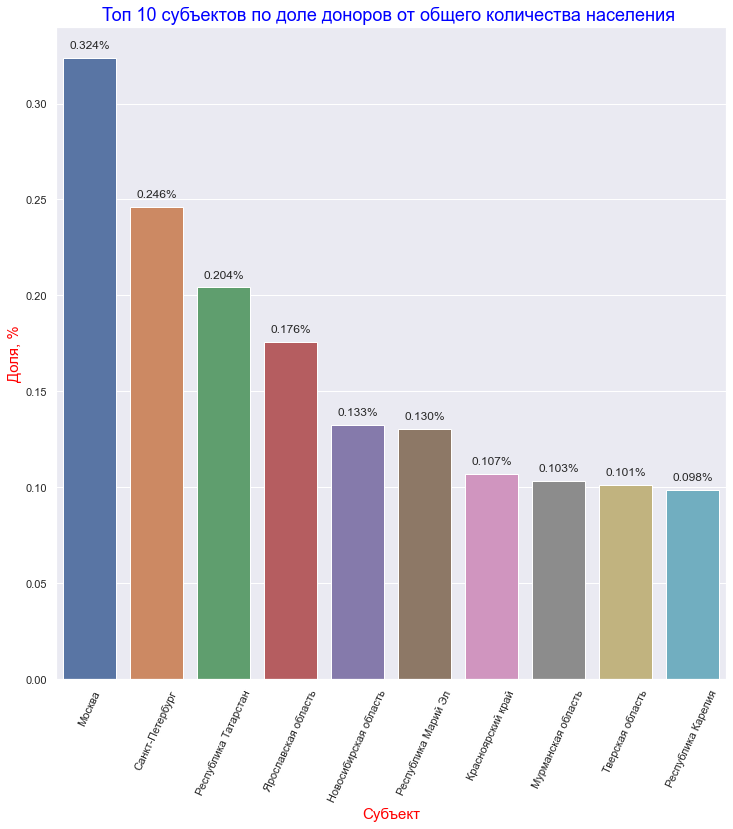

In [94]:
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x="субъект", y="доля, %", data=don_rus_ratio_top_10)
plt.xticks(rotation=65)

total = float(len(don_rus_ratio_top_10))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+.005,
            '{:.3f}%'.format(height*10/total),
            ha="center",
           fontsize=12
           ) 
    
plt.xlabel('Субъект', fontsize = 15, color = 'red')
plt.ylabel('Доля, %', fontsize = 15, color = 'red')
plt.title('Топ 10 субъектов по доле доноров от общего количества населения ', fontsize = 18, color = 'blue')

Text(0.5, 1.0, 'Худшие 10 субъектов по доле доноров от общего количества населения ')

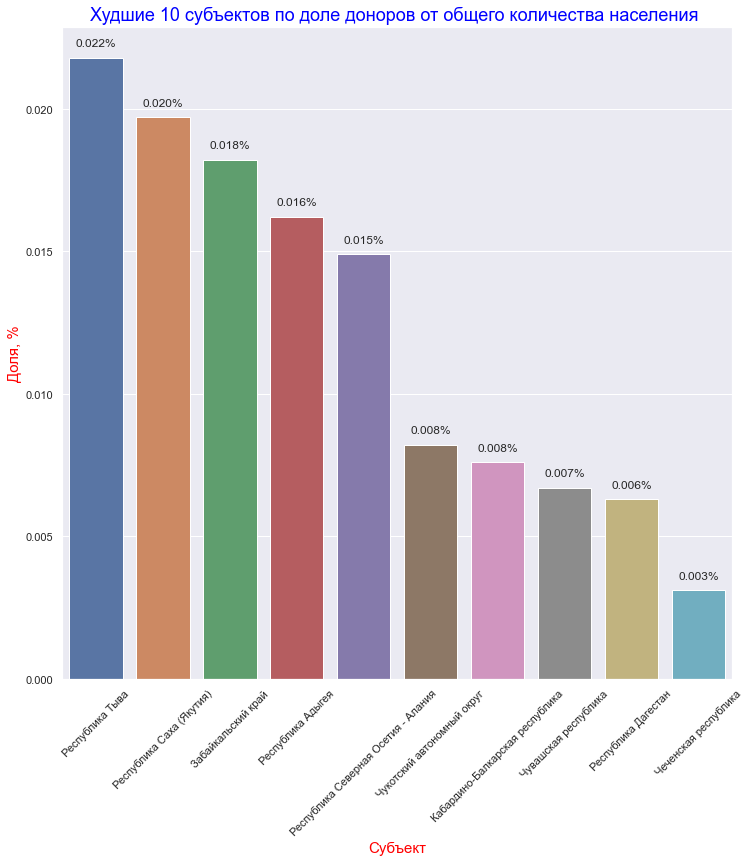

In [95]:
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x="субъект", y="доля, %", data=don_rus_ratio_worst_10)
plt.xticks(rotation=45)

total = float(len(don_rus_ratio_worst_10))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.0004,
            '{:.3f}%'.format(height*10/total),
            ha="center",
           fontsize=12
           ) 
    
plt.xlabel('Субъект', fontsize = 15, color = 'red')
plt.ylabel('Доля, %', fontsize = 15, color = 'red')
plt.title('Худшие 10 субъектов по доле доноров от общего количества населения ', fontsize = 18, color = 'blue')

## Украина

Text(0.5, 1.0, 'Топ 10 субъектов по доле доноров от общего количества населения ')

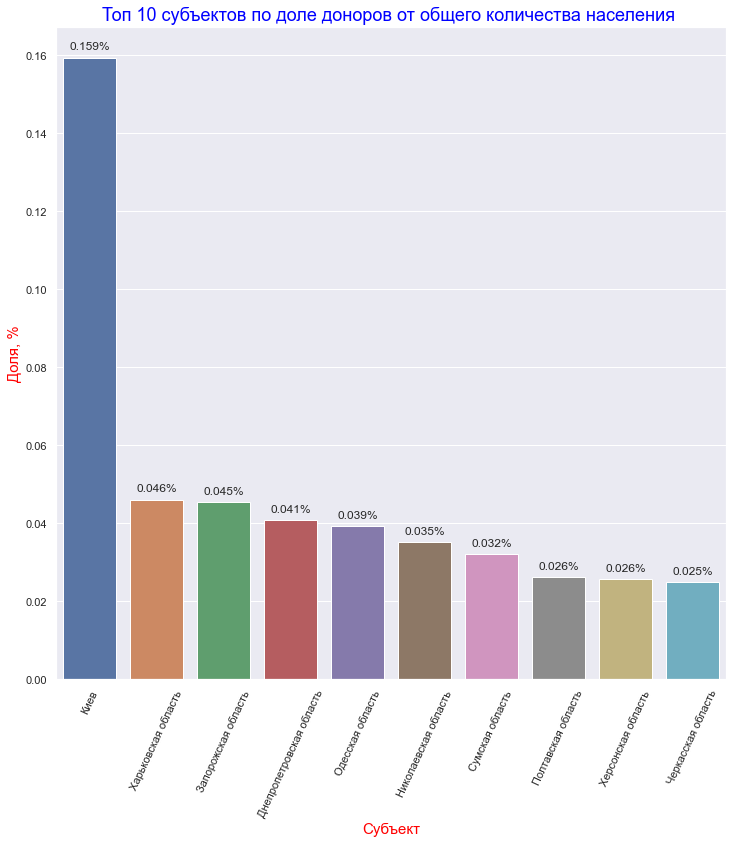

In [96]:
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x="субъект", y="доля, %", data=don_ukr_count_top_10)
plt.xticks(rotation=65)

total = float(len(don_ukr_count_top_10))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+.002,
            '{:.3f}%'.format(height*10/total),
            ha="center",
           fontsize=12
           ) 
    
plt.xlabel('Субъект', fontsize = 15, color = 'red')
plt.ylabel('Доля, %', fontsize = 15, color = 'red')
plt.title('Топ 10 субъектов по доле доноров от общего количества населения ', fontsize = 18, color = 'blue')

Text(0.5, 1.0, 'Топ 10 субъектов по доле доноров от общего количества населения ')

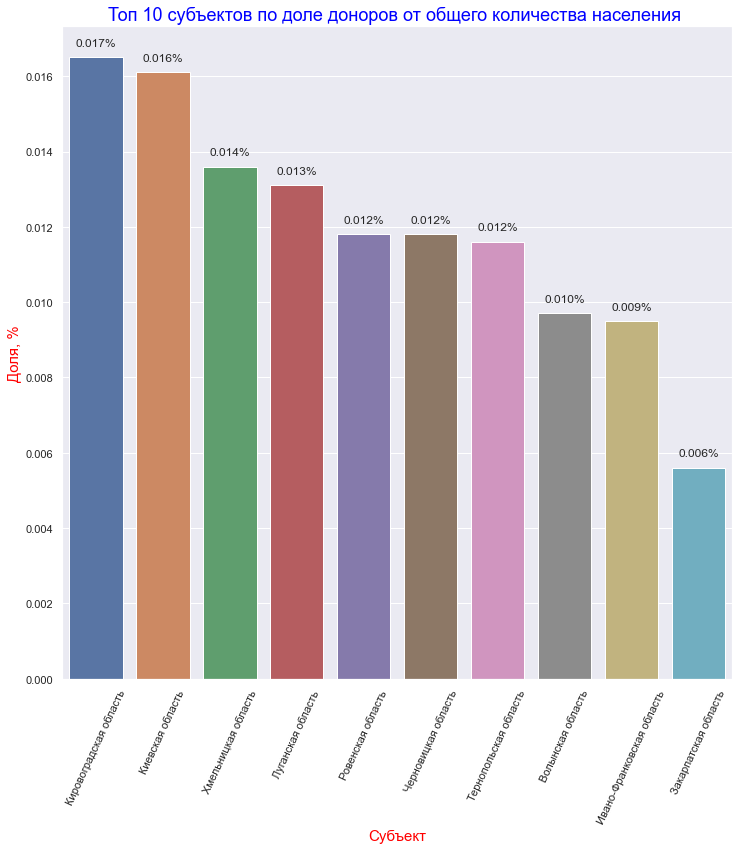

In [97]:
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x="субъект", y="доля, %", data=don_ukr_count_worst_10)
plt.xticks(rotation=65)

total = float(len(don_ukr_count_worst_10))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+.0003,
            '{:.3f}%'.format(height*10/total),
            ha="center",
           fontsize=12
           ) 
    
plt.xlabel('Субъект', fontsize = 15, color = 'red')
plt.ylabel('Доля, %', fontsize = 15, color = 'red')
plt.title('Топ 10 субъектов по доле доноров от общего количества населения ', fontsize = 18, color = 'blue')

## Республика Беларусь

Text(0.5, 1.0, 'Топ 10 субъектов по доле доноров от общего количества населения ')

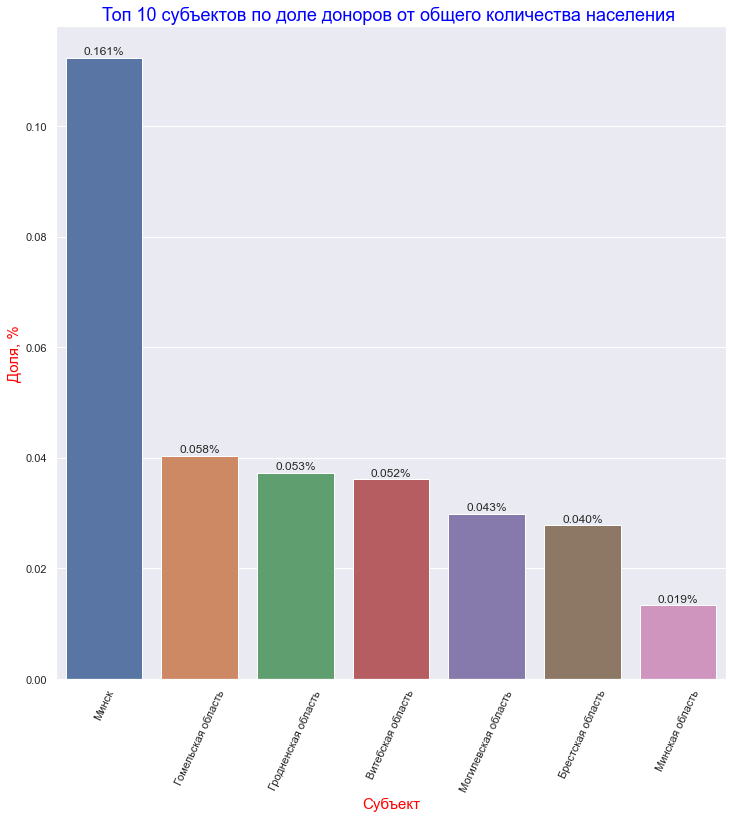

In [98]:
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x="субъект", y="доля, %", data=don_bel_ratio)
plt.xticks(rotation=65)

total = float(len(don_bel_ratio))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+.0006,
            '{:.3f}%'.format(height*10/total),
            ha="center",
           fontsize=12
           ) 
    
plt.xlabel('Субъект', fontsize = 15, color = 'red')
plt.ylabel('Доля, %', fontsize = 15, color = 'red')
plt.title('Топ 10 субъектов по доле доноров от общего количества населения ', fontsize = 18, color = 'blue')

# Республика Казахстан

Text(0.5, 1.0, 'Топ 10 субъектов по доле доноров от общего количества населения ')

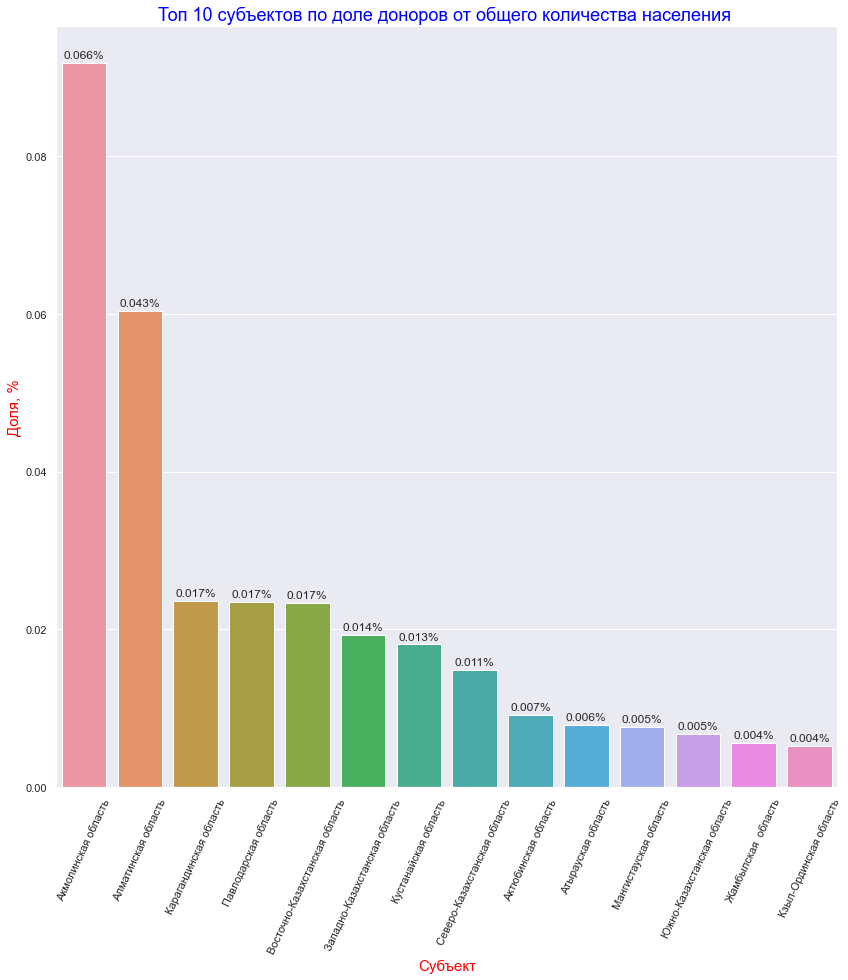

In [99]:
sns.set(rc={'figure.figsize':(14,14)})
ax = sns.barplot(x="субъект", y="доля, %", data=don_kaz_ratio)
plt.xticks(rotation=65)

total = float(len(don_kaz_ratio))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+.0006,
            '{:.3f}%'.format(height*10/total),
            ha="center",
           fontsize=12
           ) 
    
plt.xlabel('Субъект', fontsize = 15, color = 'red')
plt.ylabel('Доля, %', fontsize = 15, color = 'red')
plt.title('Топ 10 субъектов по доле доноров от общего количества населения ', fontsize = 18, color = 'blue')